# 데이터 불러오기

In [1]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/본 프로젝트


In [5]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [6]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [7]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [8]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [9]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 분식전문점

In [10]:
# 분식전문점만 남기기
sin_bunsik = df_sin_quarter[df_sin_quarter.업종명 == '분식전문점'].reset_index().drop('index', axis=1)
sin_bunsik

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,외식,식사류,분식전문점,신촌동,7465646911,240,9,12
1,2017-2,외식,식사류,분식전문점,신촌동,8126485497,234,9,15
2,2017-3,외식,식사류,분식전문점,신촌동,8094245338,230,6,10
3,2017-4,외식,식사류,분식전문점,신촌동,8477240875,228,4,6
4,2018-1,외식,식사류,분식전문점,신촌동,7617068168,231,9,6
5,2018-2,외식,식사류,분식전문점,신촌동,8511709562,237,16,10
6,2018-3,외식,식사류,분식전문점,신촌동,7390622440,241,18,14
7,2018-4,외식,식사류,분식전문점,신촌동,8794912005,243,13,11
8,2019-1,외식,식사류,분식전문점,신촌동,6377171461,241,7,9
9,2019-2,외식,식사류,분식전문점,신촌동,6792124183,252,20,9


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [11]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_bunsik['성장성'] = sin_bunsik['분기당_매출_금액'] / sin_bunsik['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_bunsik['성장성'][0] = 1

sin_bunsik

<ipython-input-11-bcb006ccec20>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bunsik['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,외식,식사류,분식전문점,신촌동,7465646911,240,9,12,1.000000
1,2017-2,외식,식사류,분식전문점,신촌동,8126485497,234,9,15,1.088517
2,2017-3,외식,식사류,분식전문점,신촌동,8094245338,230,6,10,0.996033
3,2017-4,외식,식사류,분식전문점,신촌동,8477240875,228,4,6,1.047317
4,2018-1,외식,식사류,분식전문점,신촌동,7617068168,231,9,6,0.898532
5,2018-2,외식,식사류,분식전문점,신촌동,8511709562,237,16,10,1.117452
6,2018-3,외식,식사류,분식전문점,신촌동,7390622440,241,18,14,0.868289
7,2018-4,외식,식사류,분식전문점,신촌동,8794912005,243,13,11,1.190010
8,2019-1,외식,식사류,분식전문점,신촌동,6377171461,241,7,9,0.725098
9,2019-2,외식,식사류,분식전문점,신촌동,6792124183,252,20,9,1.065068


In [12]:
# 개업률, 폐업률, 순점포증감률 추가

sin_bunsik['개업률'] = (sin_bunsik['개업점포수'] / sin_bunsik['총 점포수']) * 100
sin_bunsik['폐업률'] = (sin_bunsik['폐업점포수'] / sin_bunsik['총 점포수']) * 100
sin_bunsik['순점포증감률'] = ((sin_bunsik['개업점포수'] - sin_bunsik['폐업점포수']) / sin_bunsik['총 점포수']) * 100

# sin_bunsik

In [13]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 분식전문점만 남기기
seo_bunsik = df_seo_quarter[df_seo_quarter['업종명'] == '분식전문점'].reset_index()

################################################################################################################################################################################################

sin_bunsik['시장성'] = (sin_bunsik['분기당_매출_금액'] / sin_bunsik['총 점포수']) - (seo_bunsik['분기당_매출_금액'] / seo_bunsik['총 점포수'])

sin_bunsik = sin_bunsik[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_bunsik

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,분식전문점,7465646911,1.000000,-1.250000,1.187856e+06
1,2017-2,분식전문점,8126485497,1.088517,-2.564103,3.564498e+04
2,2017-3,분식전문점,8094245338,0.996033,-1.739130,1.265094e+06
3,2017-4,분식전문점,8477240875,1.047317,-0.877193,1.769265e+06
4,2018-1,분식전문점,7617068168,0.898532,1.298701,1.120189e+06
5,2018-2,분식전문점,8511709562,1.117452,2.531646,3.280421e+05
6,2018-3,분식전문점,7390622440,0.868289,1.659751,-2.786735e+05
7,2018-4,분식전문점,8794912005,1.190010,0.823045,1.741043e+06
8,2019-1,분식전문점,6377171461,0.725098,-0.829876,1.348501e+06
9,2019-2,분식전문점,6792124183,1.065068,4.365079,3.042091e+06


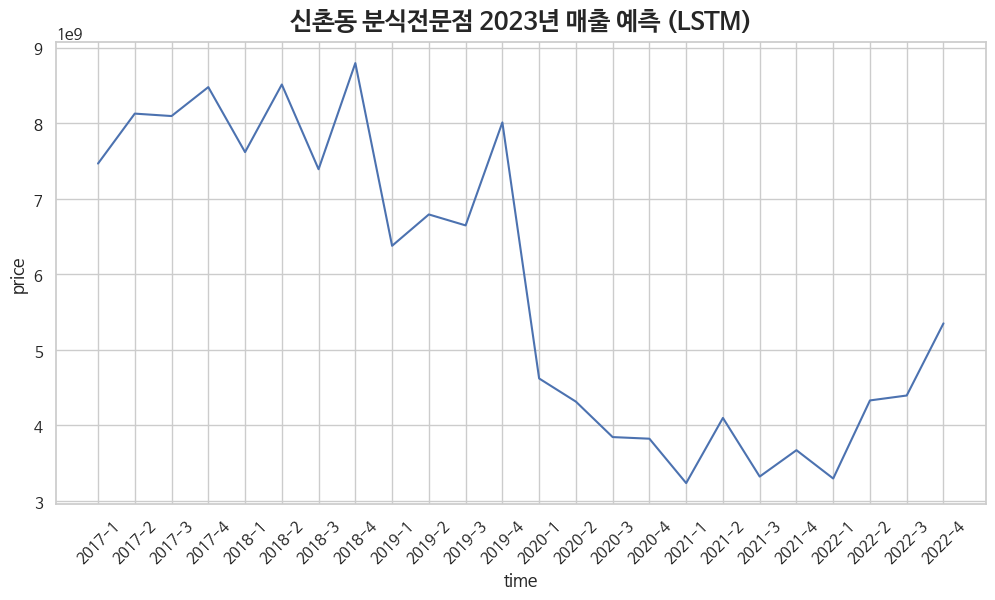

In [15]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'])
plt.title('신촌동 분식전문점 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [16]:
### X / y 데이터 생성
X = sin_bunsik[['성장성', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.187856e+06 -1.250000
1   1.088517  3.564498e+04 -2.564103
2   0.996033  1.265094e+06 -1.739130
3   1.047317  1.769265e+06 -0.877193
4   0.898532  1.120189e+06  1.298701
5   1.117452  3.280421e+05  2.531646
6   0.868289 -2.786735e+05  1.659751
7   1.190010  1.741043e+06  0.823045
8   0.725098  1.348501e+06 -0.829876
9   1.065068  3.042091e+06  4.365079
10  0.978646 -1.532132e+06  2.962963
11  1.205015  5.831175e+05  0.000000
12  0.576986 -3.018970e+06 -0.843882
13  0.933667 -4.315876e+06  0.836820
14  0.891266 -4.494597e+06  1.646091
15  0.994424 -5.039517e+06  0.000000
16  0.846345 -4.511026e+06 -0.813008
17  1.266467 -5.572466e+06  4.651163
18  0.810706 -6.556948e+06  0.766284
19  1.105043 -5.922049e+06  2.247191
20  0.897929 -4.883146e+06  0.743494
21  1.313385 -5.769202e+06  1.831502
22  1.015020 -4.968662e+06  0.000000
23  1.217157 -5.800844e+06  0.000000
---------------------------------------------------------------------------

In [17]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [18]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [19]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [20]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.59483187 0.16546297 0.3553719 ]
 [0.86932666 0.07876867 0.3553719 ]]


In [21]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [22]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7220
Epoch 1: val_loss improved from inf to 0.02227, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.7220 - val_loss: 0.0223
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6995
Epoch 2: val_loss improved from 0.02227 to 0.01961, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.6995 - val_loss: 0.0196
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6777
Epoch 3: val_loss improved from 0.01961 to 0.01723, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.6777 - val_loss: 0.0172
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6566
Epoch 4: val_loss improved from 0.01723 to 0.01509, saving model to stock_model.h5
1/1 [==============================] - 0s 73ms/step - loss: 0.6566 - val_loss: 0.0151
Epoch 5/100
1/1 [=================

In [24]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 685ms/step
[[0.11157311]
 [0.12228399]
 [0.12094721]
 [0.12837252]]


In [25]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.010934,0.111573
2022-2,0.196856,0.122284
2022-3,0.208559,0.120947
2022-4,0.380309,0.128373


In [26]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_bunsik의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.010934,0.111573,3297507231,3.856879e+09,-5.593716e+08
2022-2,0.196856,0.122284,4330897444,3.916411e+09,4.144861e+08
2022-3,0.208559,0.120947,4395945625,3.908982e+09,4.869641e+08
2022-4,0.380309,0.128373,5350558007,3.950253e+09,1.400305e+09


### 결과

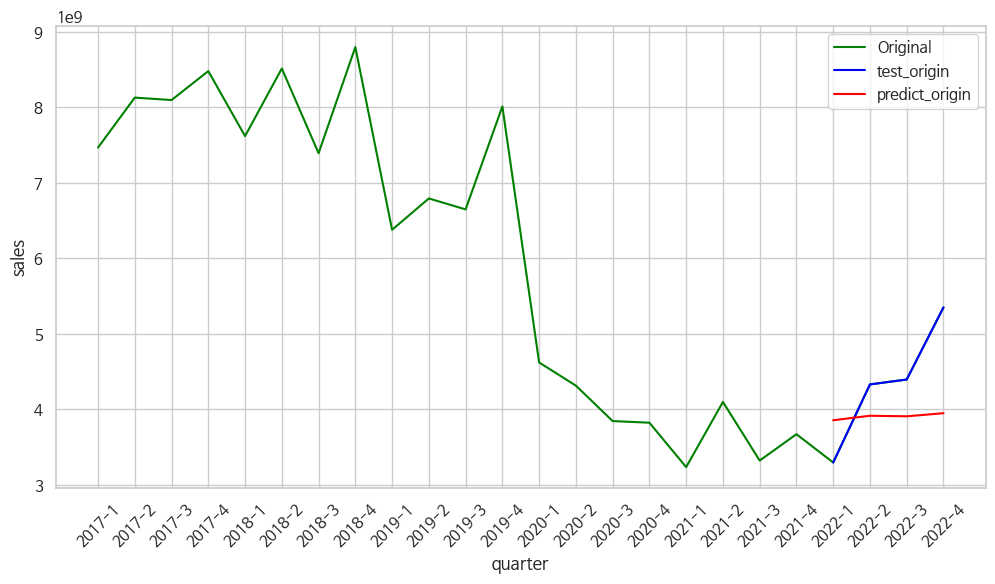

In [27]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [28]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     4.355959e+08
std      8.007723e+08
min     -5.593716e+08
25%      1.710216e+08
50%      4.507251e+08
75%      7.152994e+08
max      1.400305e+09
dtype: float64

In [29]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 20ms/step
[[0.11547255]]
--------------------------------------------------------------------------------
예측된 매출  : 3878552320.0 


## 23년 1분기 성장성 예측

In [30]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

     분기당_매출_금액           시장성    순점포증감률
0   7465646911  1.187856e+06 -1.250000
1   8126485497  3.564498e+04 -2.564103
2   8094245338  1.265094e+06 -1.739130
3   8477240875  1.769265e+06 -0.877193
4   7617068168  1.120189e+06  1.298701
5   8511709562  3.280421e+05  2.531646
6   7390622440 -2.786735e+05  1.659751
7   8794912005  1.741043e+06  0.823045
8   6377171461  1.348501e+06 -0.829876
9   6792124183  3.042091e+06  4.365079
10  6647088029 -1.532132e+06  2.962963
11  8009839855  5.831175e+05  0.000000
12  4621561501 -3.018970e+06 -0.843882
13  4315000424 -4.315876e+06  0.836820
14  3845812721 -4.494597e+06  1.646091
15  3824368223 -5.039517e+06  0.000000
16  3236735681 -4.511026e+06 -0.813008
17  4099219003 -5.572466e+06  4.651163
18  3323261563 -6.556948e+06  0.766284
19  3672348210 -5.922049e+06  2.247191
20  3297507231 -4.883146e+06  0.743494
21  4330897444 -5.769202e+06  1.831502
22  4395945625 -4.968662e+06  0.000000
23  5350558007 -5.800844e+06  0.000000
-------------------------

In [31]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [32]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [33]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.2085594  0.16546297 0.3553719 ]
 [0.38030861 0.07876867 0.3553719 ]]


In [34]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [35]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4312
Epoch 1: val_loss improved from inf to 0.30133, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.4312 - val_loss: 0.3013
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4131
Epoch 2: val_loss improved from 0.30133 to 0.29251, saving model to stock_model.h5
1/1 [==============================] - 0s 124ms/step - loss: 0.4131 - val_loss: 0.2925
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3957
Epoch 3: val_loss improved from 0.29251 to 0.28401, saving model to stock_model.h5
1/1 [==============================] - 0s 172ms/step - loss: 0.3957 - val_loss: 0.2840
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3790
Epoch 4: val_loss improved from 0.28401 to 0.27581, saving model to stock_model.h5
1/1 [==============================] - 0s 141ms/step - loss: 0.3790 - val_loss: 0.2758
Epoch 5/100
1/1 [==============

In [37]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 681ms/step
[[0.32748893]
 [0.3577266 ]
 [0.35143274]
 [0.374912  ]]


In [38]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.435828,0.327489
2022-2,1.000000,0.357727
2022-3,0.594832,0.351433
2022-4,0.869327,0.374912


In [39]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 3].values       # 성장성이 sin_bunsik의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.435828,0.327489,0.897929,0.818148,0.079781
2022-2,1.000000,0.357727,1.313385,0.840415,0.472970
2022-3,0.594832,0.351433,1.015020,0.835780,0.179239
2022-4,0.869327,0.374912,1.217157,0.853071,0.364087


### 결과

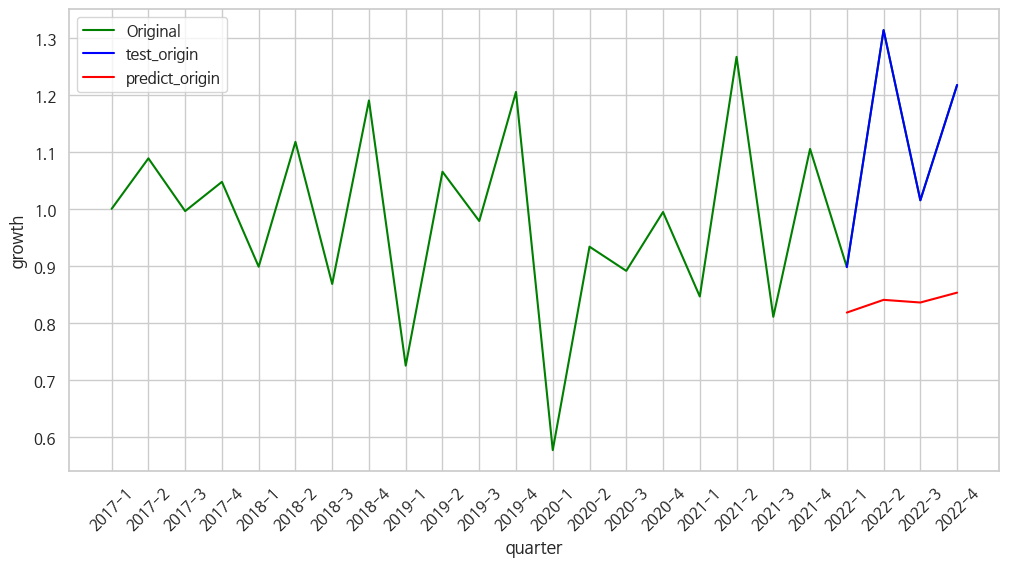

In [40]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [41]:
## error의 요약 통계량
error.describe()

count    4.000000
mean     0.274019
std      0.177394
min      0.079781
25%      0.154374
50%      0.271663
75%      0.391308
max      0.472970
dtype: float64

In [42]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 21ms/step
[[0.35940152]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8416486978530884 


## 23년 1분기 시장성 예측

In [43]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_bunsik[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_bunsik.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액    순점포증감률
0   1.000000  7465646911 -1.250000
1   1.088517  8126485497 -2.564103
2   0.996033  8094245338 -1.739130
3   1.047317  8477240875 -0.877193
4   0.898532  7617068168  1.298701
5   1.117452  8511709562  2.531646
6   0.868289  7390622440  1.659751
7   1.190010  8794912005  0.823045
8   0.725098  6377171461 -0.829876
9   1.065068  6792124183  4.365079
10  0.978646  6647088029  2.962963
11  1.205015  8009839855  0.000000
12  0.576986  4621561501 -0.843882
13  0.933667  4315000424  0.836820
14  0.891266  3845812721  1.646091
15  0.994424  3824368223  0.000000
16  0.846345  3236735681 -0.813008
17  1.266467  4099219003  4.651163
18  0.810706  3323261563  0.766284
19  1.105043  3672348210  2.247191
20  0.897929  3297507231  0.743494
21  1.313385  4330897444  1.831502
22  1.015020  4395945625  0.000000
23  1.217157  5350558007  0.000000
--------------------------------------------------------------------------------
             시장성
0   1.187856e+06
1   3.5644

In [44]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [45]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [46]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.59483187 0.2085594  0.3553719 ]
 [0.86932666 0.38030861 0.3553719 ]]


In [47]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [48]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6901
Epoch 1: val_loss improved from inf to 0.04456, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6901 - val_loss: 0.0446
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6677
Epoch 2: val_loss improved from 0.04456 to 0.04074, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.6677 - val_loss: 0.0407
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6462
Epoch 3: val_loss improved from 0.04074 to 0.03720, saving model to stock_model.h5
1/1 [==============================] - 0s 70ms/step - loss: 0.6462 - val_loss: 0.0372
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6253
Epoch 4: val_loss improved from 0.03720 to 0.03391, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.6253 - val_loss: 0.0339
Epoch 5/100
1/1 [=================

In [50]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 657ms/step
[[0.1555925 ]
 [0.16892998]
 [0.16595721]
 [0.18558435]]


In [51]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.174372,0.155593
2022-2,0.082065,0.168930
2022-3,0.165463,0.165957
2022-4,0.078769,0.185584


In [52]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 5].values       # 시장성이 sin_bunsik의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.174372,0.155593,-4.883146e+06,-5063409.5,1.802633e+05
2022-2,0.082065,0.168930,-5.769202e+06,-4935382.5,-8.338198e+05
2022-3,0.165463,0.165957,-4.968662e+06,-4963918.0,-4.744454e+03
2022-4,0.078769,0.185584,-5.800844e+06,-4775516.5,-1.025328e+06


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


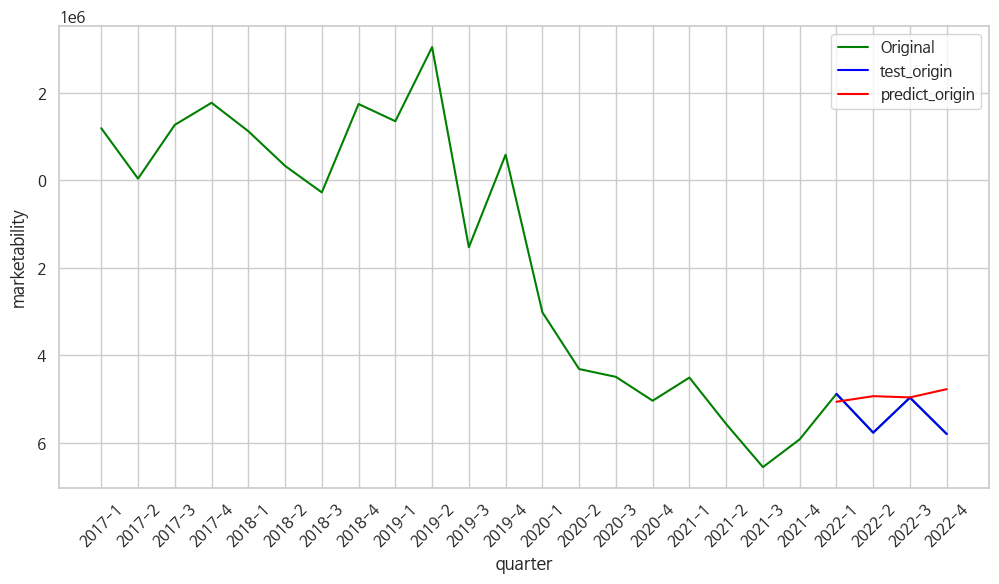

In [53]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [54]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -4.209072e+05
std      5.973326e+05
min     -1.025328e+06
25%     -8.816968e+05
50%     -4.192821e+05
75%      4.150748e+04
max      1.802633e+05
dtype: float64

In [55]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 20ms/step
[[0.16952321]]
--------------------------------------------------------------------------------
예측된 시장성  : -4929688.0 


## 23년 1분기 순점포증감률 예측

In [56]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_bunsik[['성장성', '분기당_매출_금액', '시장성']]
y = sin_bunsik.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액           시장성
0   1.000000  7465646911  1.187856e+06
1   1.088517  8126485497  3.564498e+04
2   0.996033  8094245338  1.265094e+06
3   1.047317  8477240875  1.769265e+06
4   0.898532  7617068168  1.120189e+06
5   1.117452  8511709562  3.280421e+05
6   0.868289  7390622440 -2.786735e+05
7   1.190010  8794912005  1.741043e+06
8   0.725098  6377171461  1.348501e+06
9   1.065068  6792124183  3.042091e+06
10  0.978646  6647088029 -1.532132e+06
11  1.205015  8009839855  5.831175e+05
12  0.576986  4621561501 -3.018970e+06
13  0.933667  4315000424 -4.315876e+06
14  0.891266  3845812721 -4.494597e+06
15  0.994424  3824368223 -5.039517e+06
16  0.846345  3236735681 -4.511026e+06
17  1.266467  4099219003 -5.572466e+06
18  0.810706  3323261563 -6.556948e+06
19  1.105043  3672348210 -5.922049e+06
20  0.897929  3297507231 -4.883146e+06
21  1.313385  4330897444 -5.769202e+06
22  1.015020  4395945625 -4.968662e+06
23  1.217157  5350558007 -5.800844e+06
-------------------------

In [57]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [58]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [59]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.59483187 0.2085594  0.16546297]
 [0.86932666 0.38030861 0.07876867]]


In [60]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [61]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3552
Epoch 1: val_loss improved from inf to 0.31341, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.3552 - val_loss: 0.3134
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3388
Epoch 2: val_loss improved from 0.31341 to 0.30405, saving model to stock_model.h5
1/1 [==============================] - 0s 72ms/step - loss: 0.3388 - val_loss: 0.3040
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3231
Epoch 3: val_loss improved from 0.30405 to 0.29500, saving model to stock_model.h5
1/1 [==============================] - 0s 82ms/step - loss: 0.3231 - val_loss: 0.2950
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3081
Epoch 4: val_loss improved from 0.29500 to 0.28624, saving model to stock_model.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.3081 - val_loss: 0.2862
Epoch 5/100
1/1 [=================

In [63]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.26226464]
 [0.3066832 ]
 [0.31816292]
 [0.35980314]]


In [64]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.458417,0.262265
2022-2,0.609209,0.306683
2022-3,0.355372,0.318163
2022-4,0.355372,0.359803


In [65]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_bunsik의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.458417,0.262265,0.743494,-0.671794,1.415288
2022-2,0.609209,0.306683,1.831502,-0.351302,2.182804
2022-3,0.355372,0.318163,0.000000,-0.268473,0.268473
2022-4,0.355372,0.359803,0.000000,0.031973,-0.031973


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


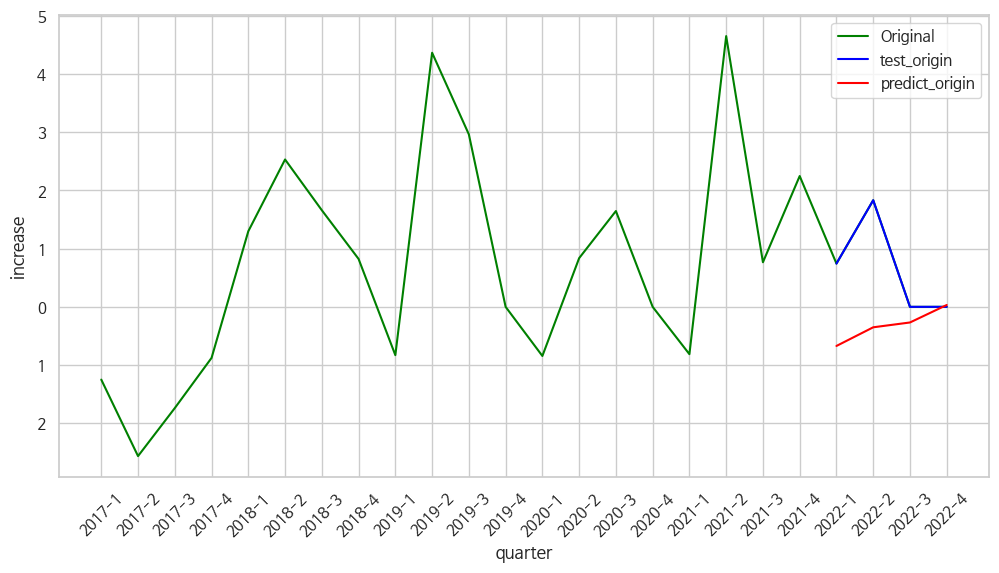

In [66]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [67]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.958648
std      1.027091
min     -0.031973
25%      0.193361
50%      0.841880
75%      1.607167
max      2.182804
dtype: float64

In [68]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 21ms/step
[[0.35254842]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.020372159779071808 


## 원본 데이터에 예측값 추가하기

In [69]:
print(sales)
print(growth)
print(marketability)
print(increase)

3878552300.0
0.8416487
-4929688.0
-0.02037216


In [70]:
sin_bunsik.loc[24] = ['2023-1', '분식전문점', sales, growth, increase, marketability]

<ipython-input-70-c54dbd32a1b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bunsik.loc[24] = ['2023-1', '분식전문점', sales, growth, increase, marketability]


In [71]:
sin_bunsik

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,분식전문점,7.465647e+09,1.000000,-1.250000,1.187856e+06
1,2017-2,분식전문점,8.126485e+09,1.088517,-2.564103,3.564498e+04
2,2017-3,분식전문점,8.094245e+09,0.996033,-1.739130,1.265094e+06
3,2017-4,분식전문점,8.477241e+09,1.047317,-0.877193,1.769265e+06
4,2018-1,분식전문점,7.617068e+09,0.898532,1.298701,1.120189e+06
5,2018-2,분식전문점,8.511710e+09,1.117452,2.531646,3.280421e+05
6,2018-3,분식전문점,7.390622e+09,0.868289,1.659751,-2.786735e+05
7,2018-4,분식전문점,8.794912e+09,1.190010,0.823045,1.741043e+06
8,2019-1,분식전문점,6.377171e+09,0.725098,-0.829876,1.348501e+06
9,2019-2,분식전문점,6.792124e+09,1.065068,4.365079,3.042091e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [72]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_bunsik[['성장성', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.187856e+06 -1.250000
1   1.088517  3.564498e+04 -2.564103
2   0.996033  1.265094e+06 -1.739130
3   1.047317  1.769265e+06 -0.877193
4   0.898532  1.120189e+06  1.298701
5   1.117452  3.280421e+05  2.531646
6   0.868289 -2.786735e+05  1.659751
7   1.190010  1.741043e+06  0.823045
8   0.725098  1.348501e+06 -0.829876
9   1.065068  3.042091e+06  4.365079
10  0.978646 -1.532132e+06  2.962963
11  1.205015  5.831175e+05  0.000000
12  0.576986 -3.018970e+06 -0.843882
13  0.933667 -4.315876e+06  0.836820
14  0.891266 -4.494597e+06  1.646091
15  0.994424 -5.039517e+06  0.000000
16  0.846345 -4.511026e+06 -0.813008
17  1.266467 -5.572466e+06  4.651163
18  0.810706 -6.556948e+06  0.766284
19  1.105043 -5.922049e+06  2.247191
20  0.897929 -4.883146e+06  0.743494
21  1.313385 -5.769202e+06  1.831502
22  1.015020 -4.968662e+06  0.000000
23  1.217157 -5.800844e+06  0.000000
24  0.841649 -4.929688e+06 -0.020372
--------------------------------------

In [73]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [74]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.86932666 0.07876867 0.3553719 ]
 [0.35940151 0.16952321 0.35254842]]


In [75]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [76]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6637
Epoch 1: val_loss improved from inf to 0.01310, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.6637 - val_loss: 0.0131
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6426
Epoch 2: val_loss improved from 0.01310 to 0.01132, saving model to stock_model.h5
1/1 [==============================] - 0s 73ms/step - loss: 0.6426 - val_loss: 0.0113
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6221
Epoch 3: val_loss improved from 0.01132 to 0.00977, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.6221 - val_loss: 0.0098
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6023
Epoch 4: val_loss improved from 0.00977 to 0.00844, saving model to stock_model.h5
1/1 [==============================] - 0s 70ms/step - loss: 0.6023 - val_loss: 0.0084
Epoch 5/100
1/1 [=================

In [78]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 660ms/step
[[0.08911674]
 [0.08796215]
 [0.09346916]
 [0.08413321]]


In [79]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.196856,0.089117
2022-3,0.208559,0.087962
2022-4,0.380309,0.093469
2023-1,0.115473,0.084133


In [80]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_bunsik의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.196856,0.089117,4.330897e+09,3.732062e+09,5.988352e+08
2022-3,0.208559,0.087962,4.395946e+09,3.725645e+09,6.703006e+08
2022-4,0.380309,0.093469,5.350558e+09,3.756254e+09,1.594304e+09
2023-1,0.115473,0.084133,3.878552e+09,3.704363e+09,1.741893e+08


In [81]:
df_test = df_test.reset_index()

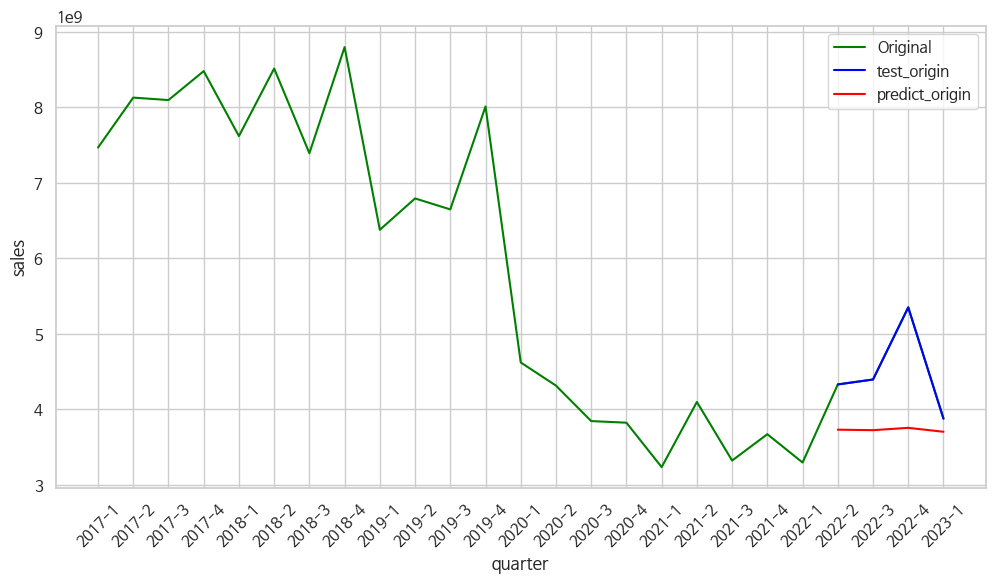

In [82]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [83]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     7.594074e+08
std      5.981239e+08
min      1.741893e+08
25%      4.926738e+08
50%      6.345679e+08
75%      9.013015e+08
max      1.594304e+09
dtype: float64

In [84]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 21ms/step
[[0.08352019]]
--------------------------------------------------------------------------------
예측된 매출  : 3700955648.0 


### 성장성

In [85]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   7.465647e+09  1.187856e+06 -1.250000
1   8.126485e+09  3.564498e+04 -2.564103
2   8.094245e+09  1.265094e+06 -1.739130
3   8.477241e+09  1.769265e+06 -0.877193
4   7.617068e+09  1.120189e+06  1.298701
5   8.511710e+09  3.280421e+05  2.531646
6   7.390622e+09 -2.786735e+05  1.659751
7   8.794912e+09  1.741043e+06  0.823045
8   6.377171e+09  1.348501e+06 -0.829876
9   6.792124e+09  3.042091e+06  4.365079
10  6.647088e+09 -1.532132e+06  2.962963
11  8.009840e+09  5.831175e+05  0.000000
12  4.621562e+09 -3.018970e+06 -0.843882
13  4.315000e+09 -4.315876e+06  0.836820
14  3.845813e+09 -4.494597e+06  1.646091
15  3.824368e+09 -5.039517e+06  0.000000
16  3.236736e+09 -4.511026e+06 -0.813008
17  4.099219e+09 -5.572466e+06  4.651163
18  3.323262e+09 -6.556948e+06  0.766284
19  3.672348e+09 -5.922049e+06  2.247191
20  3.297507e+09 -4.883146e+06  0.743494
21  4.330897e+09 -5.769202e+06  1.831502
22  4.395946e+09 -4.968662e+06  0.000000
23  5.350558e+09

In [86]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [87]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.38030861 0.07876867 0.3553719 ]
 [0.11547252 0.16952321 0.35254842]]


In [88]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [89]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3921
Epoch 1: val_loss improved from inf to 0.32486, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3921 - val_loss: 0.3249
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3756
Epoch 2: val_loss improved from 0.32486 to 0.31525, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.3756 - val_loss: 0.3152
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3597
Epoch 3: val_loss improved from 0.31525 to 0.30594, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.3597 - val_loss: 0.3059
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3445
Epoch 4: val_loss improved from 0.30594 to 0.29690, saving model to stock_model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.3445 - val_loss: 0.2969
Epoch 5/100
1/1 [=================

In [91]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 672ms/step
[[0.36548796]
 [0.3600301 ]
 [0.38387167]
 [0.36948133]]


In [92]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,1.000000,0.365488
2022-3,0.594832,0.360030
2022-4,0.869327,0.383872
2023-1,0.359402,0.369481


In [93]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 3].values       # 성장성이 sin_bunsik의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,1.000000,0.365488,1.313385,0.846131,0.467255
2022-3,0.594832,0.360030,1.015020,0.842112,0.172908
2022-4,0.869327,0.383872,1.217157,0.859669,0.357489
2023-1,0.359402,0.369481,0.841649,0.849072,-0.007423


In [94]:
df_test = df_test.reset_index()

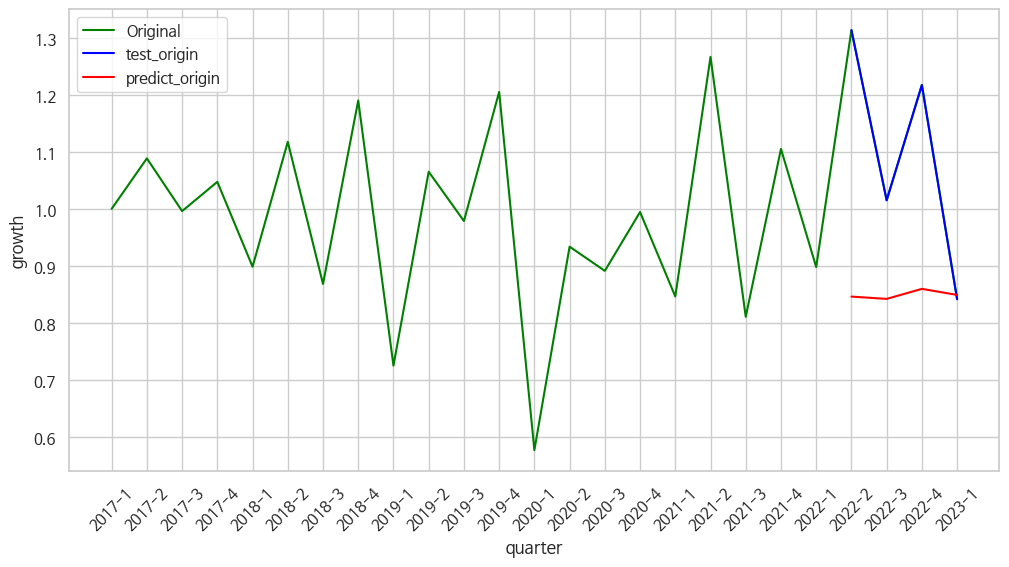

In [95]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [96]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.247557
std      0.208917
min     -0.007423
25%      0.127825
50%      0.265198
75%      0.384930
max      0.467255
dtype: float64

In [97]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 20ms/step
[[0.3700804]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8495125770568848 


### 시장성

In [98]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_bunsik.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   7.465647e+09  1.000000 -1.250000
1   8.126485e+09  1.088517 -2.564103
2   8.094245e+09  0.996033 -1.739130
3   8.477241e+09  1.047317 -0.877193
4   7.617068e+09  0.898532  1.298701
5   8.511710e+09  1.117452  2.531646
6   7.390622e+09  0.868289  1.659751
7   8.794912e+09  1.190010  0.823045
8   6.377171e+09  0.725098 -0.829876
9   6.792124e+09  1.065068  4.365079
10  6.647088e+09  0.978646  2.962963
11  8.009840e+09  1.205015  0.000000
12  4.621562e+09  0.576986 -0.843882
13  4.315000e+09  0.933667  0.836820
14  3.845813e+09  0.891266  1.646091
15  3.824368e+09  0.994424  0.000000
16  3.236736e+09  0.846345 -0.813008
17  4.099219e+09  1.266467  4.651163
18  3.323262e+09  0.810706  0.766284
19  3.672348e+09  1.105043  2.247191
20  3.297507e+09  0.897929  0.743494
21  4.330897e+09  1.313385  1.831502
22  4.395946e+09  1.015020  0.000000
23  5.350558e+09  1.217157  0.000000
24  3.878552e+09  0.841649 -0.020372
--------------------------------------

In [99]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [100]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.38030861 0.86932666 0.3553719 ]
 [0.11547252 0.35940151 0.35254842]]


In [101]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [102]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [103]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6309
Epoch 1: val_loss improved from inf to 0.03138, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.6309 - val_loss: 0.0314
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6099
Epoch 2: val_loss improved from 0.03138 to 0.02835, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.6099 - val_loss: 0.0284
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5898
Epoch 3: val_loss improved from 0.02835 to 0.02557, saving model to stock_model.h5
1/1 [==============================] - 0s 100ms/step - loss: 0.5898 - val_loss: 0.0256
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5703
Epoch 4: val_loss improved from 0.02557 to 0.02300, saving model to stock_model.h5
1/1 [==============================] - 0s 127ms/step - loss: 0.5703 - val_loss: 0.0230
Epoch 5/100
1/1 [===============

In [104]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 644ms/step
[[0.14618029]
 [0.1433606 ]
 [0.16055007]
 [0.15317382]]


In [105]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.082065,0.146180
2022-3,0.165463,0.143361
2022-4,0.078769,0.160550
2023-1,0.169523,0.153174


In [106]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 5].values       # 시장성이 sin_bunsik의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.082065,0.146180,-5.769202e+06,-5153757.5,-615444.791765
2022-3,0.165463,0.143361,-4.968662e+06,-5180824.0,212161.545713
2022-4,0.078769,0.160550,-5.800844e+06,-5015821.5,-785022.894037
2023-1,0.169523,0.153174,-4.929688e+06,-5086626.5,156938.500000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


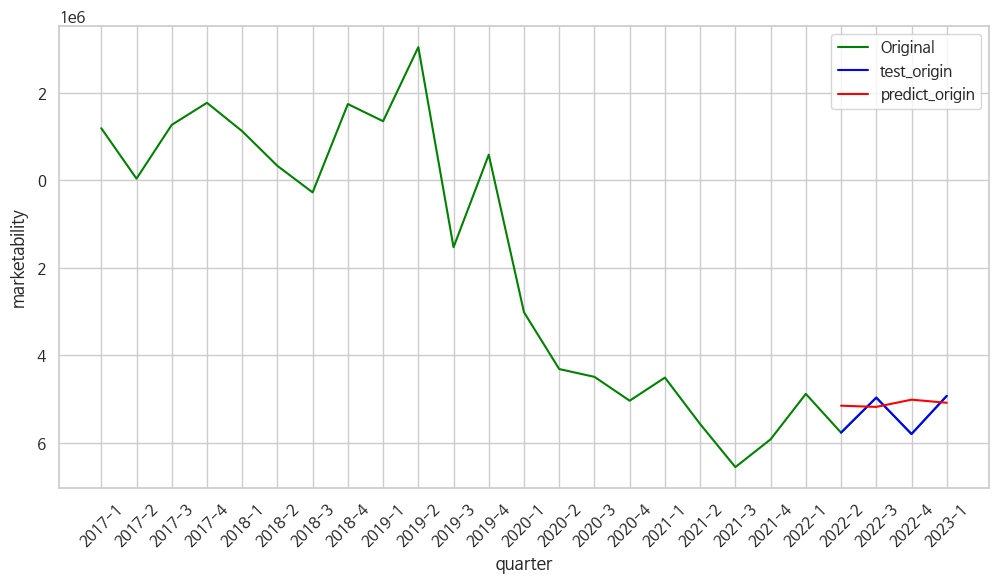

In [107]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [108]:
### error의 요약 통계량
error.describe()

count         4.000000
mean    -257841.910022
std      515992.780272
min     -785022.894037
25%     -657839.317333
50%     -229253.145882
75%      170744.261428
max      212161.545713
dtype: float64

In [109]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 25ms/step
[[0.15523772]]
--------------------------------------------------------------------------------
예측된 시장성  : -5066815.5 


### 순점포증감률

In [110]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '시장성']]
y = sin_bunsik.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   7.465647e+09  1.000000  1.187856e+06
1   8.126485e+09  1.088517  3.564498e+04
2   8.094245e+09  0.996033  1.265094e+06
3   8.477241e+09  1.047317  1.769265e+06
4   7.617068e+09  0.898532  1.120189e+06
5   8.511710e+09  1.117452  3.280421e+05
6   7.390622e+09  0.868289 -2.786735e+05
7   8.794912e+09  1.190010  1.741043e+06
8   6.377171e+09  0.725098  1.348501e+06
9   6.792124e+09  1.065068  3.042091e+06
10  6.647088e+09  0.978646 -1.532132e+06
11  8.009840e+09  1.205015  5.831175e+05
12  4.621562e+09  0.576986 -3.018970e+06
13  4.315000e+09  0.933667 -4.315876e+06
14  3.845813e+09  0.891266 -4.494597e+06
15  3.824368e+09  0.994424 -5.039517e+06
16  3.236736e+09  0.846345 -4.511026e+06
17  4.099219e+09  1.266467 -5.572466e+06
18  3.323262e+09  0.810706 -6.556948e+06
19  3.672348e+09  1.105043 -5.922049e+06
20  3.297507e+09  0.897929 -4.883146e+06
21  4.330897e+09  1.313385 -5.769202e+06
22  4.395946e+09  1.015020 -4.968662e+06
23  5.350558e+09

In [111]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [112]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.38030861 0.86932666 0.07876867]
 [0.11547252 0.35940151 0.16952321]]


In [113]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [114]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [115]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3221
Epoch 1: val_loss improved from inf to 0.34229, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.3221 - val_loss: 0.3423
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3069
Epoch 2: val_loss improved from 0.34229 to 0.33254, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.3069 - val_loss: 0.3325
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2923
Epoch 3: val_loss improved from 0.33254 to 0.32307, saving model to stock_model.h5
1/1 [==============================] - 0s 80ms/step - loss: 0.2923 - val_loss: 0.3231
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2783
Epoch 4: val_loss improved from 0.32307 to 0.31385, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.2783 - val_loss: 0.3139
Epoch 5/100
1/1 [=================

In [116]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.2740757 ]
 [0.28578442]
 [0.3234672 ]
 [0.3249368 ]]


In [117]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.609209,0.274076
2022-3,0.355372,0.285784
2022-4,0.355372,0.323467
2023-1,0.352548,0.324937


In [118]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_bunsik의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.609209,0.274076,1.831502,-0.586574,2.418076
2022-3,0.355372,0.285784,0.000000,-0.502092,0.502092
2022-4,0.355372,0.323467,0.000000,-0.230201,0.230201
2023-1,0.352548,0.324937,-0.020372,-0.219597,0.199225


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


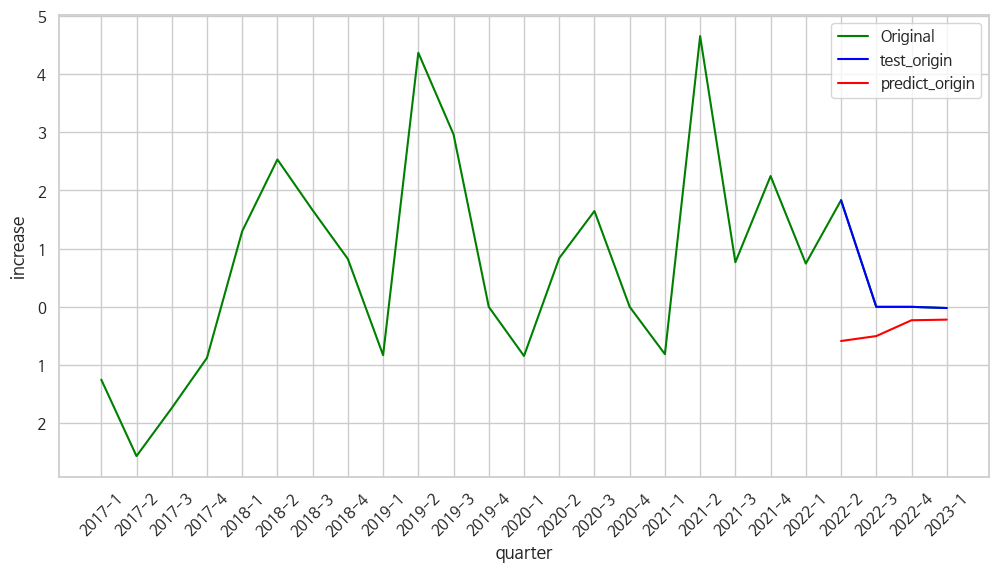

In [119]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [120]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.837398
std      1.062532
min      0.199225
25%      0.222457
50%      0.366147
75%      0.981088
max      2.418076
dtype: float64

In [121]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 20ms/step
[[0.32495385]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.21947427093982697 


### 추가


In [122]:
sin_bunsik.loc[25] = ['2023-2', '분식전문점', sales, growth, increase, marketability]

<ipython-input-122-caf27a0f321f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bunsik.loc[25] = ['2023-2', '분식전문점', sales, growth, increase, marketability]


In [123]:
sin_bunsik

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,분식전문점,7.465647e+09,1.000000,-1.250000,1.187856e+06
1,2017-2,분식전문점,8.126485e+09,1.088517,-2.564103,3.564498e+04
2,2017-3,분식전문점,8.094245e+09,0.996033,-1.739130,1.265094e+06
3,2017-4,분식전문점,8.477241e+09,1.047317,-0.877193,1.769265e+06
4,2018-1,분식전문점,7.617068e+09,0.898532,1.298701,1.120189e+06
5,2018-2,분식전문점,8.511710e+09,1.117452,2.531646,3.280421e+05
6,2018-3,분식전문점,7.390622e+09,0.868289,1.659751,-2.786735e+05
7,2018-4,분식전문점,8.794912e+09,1.190010,0.823045,1.741043e+06
8,2019-1,분식전문점,6.377171e+09,0.725098,-0.829876,1.348501e+06
9,2019-2,분식전문점,6.792124e+09,1.065068,4.365079,3.042091e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [124]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_bunsik[['성장성', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.187856e+06 -1.250000
1   1.088517  3.564498e+04 -2.564103
2   0.996033  1.265094e+06 -1.739130
3   1.047317  1.769265e+06 -0.877193
4   0.898532  1.120189e+06  1.298701
5   1.117452  3.280421e+05  2.531646
6   0.868289 -2.786735e+05  1.659751
7   1.190010  1.741043e+06  0.823045
8   0.725098  1.348501e+06 -0.829876
9   1.065068  3.042091e+06  4.365079
10  0.978646 -1.532132e+06  2.962963
11  1.205015  5.831175e+05  0.000000
12  0.576986 -3.018970e+06 -0.843882
13  0.933667 -4.315876e+06  0.836820
14  0.891266 -4.494597e+06  1.646091
15  0.994424 -5.039517e+06  0.000000
16  0.846345 -4.511026e+06 -0.813008
17  1.266467 -5.572466e+06  4.651163
18  0.810706 -6.556948e+06  0.766284
19  1.105043 -5.922049e+06  2.247191
20  0.897929 -4.883146e+06  0.743494
21  1.313385 -5.769202e+06  1.831502
22  1.015020 -4.968662e+06  0.000000
23  1.217157 -5.800844e+06  0.000000
24  0.841649 -4.929688e+06 -0.020372
25  0.849513 -5.066816e+06 -0.219474
-

In [125]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [126]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.35940151 0.16952321 0.35254842]
 [0.37008033 0.15523767 0.32495386]]


In [127]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [128]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [129]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6126
Epoch 1: val_loss improved from inf to 0.01250, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.6126 - val_loss: 0.0125
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5928
Epoch 2: val_loss improved from 0.01250 to 0.01081, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.5928 - val_loss: 0.0108
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5736
Epoch 3: val_loss improved from 0.01081 to 0.00934, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.5736 - val_loss: 0.0093
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5551
Epoch 4: val_loss improved from 0.00934 to 0.00808, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.5551 - val_loss: 0.0081
Epoch 5/100
1/1 [=================

In [130]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 658ms/step
[[0.08807458]
 [0.09363534]
 [0.0842521 ]
 [0.08364733]]


In [131]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.208559,0.088075
2022-4,0.380309,0.093635
2023-1,0.115473,0.084252
2023-2,0.083520,0.083647


In [132]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_bunsik의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.208559,0.088075,4.395946e+09,3.726270e+09,6.696759e+08
2022-4,0.380309,0.093635,5.350558e+09,3.757177e+09,1.593381e+09
2023-1,0.115473,0.084252,3.878552e+09,3.705024e+09,1.735286e+08
2023-2,0.083520,0.083647,3.700956e+09,3.701662e+09,-7.065600e+05


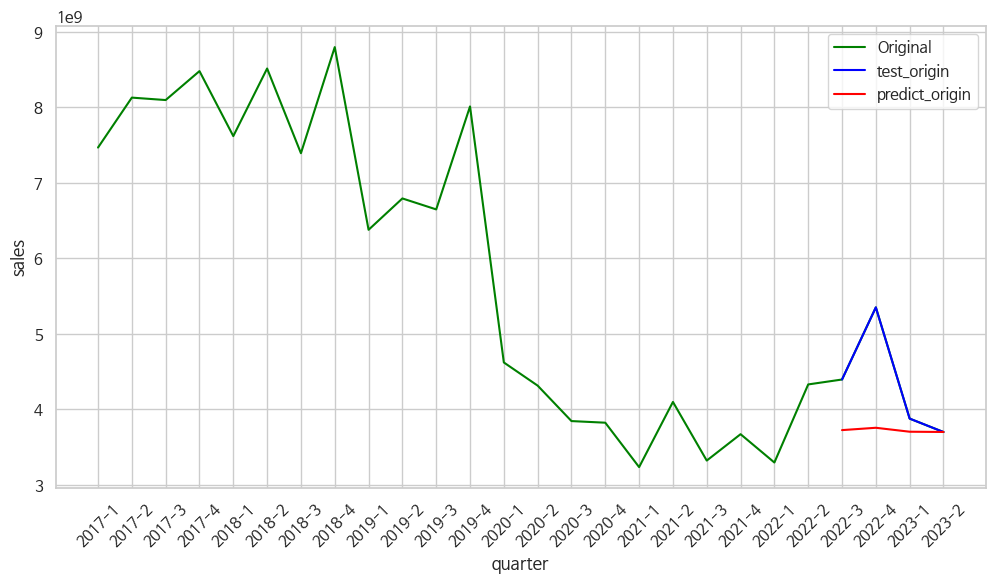

In [133]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [134]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     6.089697e+08
std      7.150907e+08
min     -7.065600e+05
25%      1.299698e+08
50%      4.216023e+08
75%      9.006021e+08
max      1.593381e+09
dtype: float64

In [135]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 20ms/step
[[0.07449098]]
--------------------------------------------------------------------------------
예측된 매출  : 3650769664.0 


### 성장성

In [136]:
X = sin_bunsik[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   7.465647e+09  1.187856e+06 -1.250000
1   8.126485e+09  3.564498e+04 -2.564103
2   8.094245e+09  1.265094e+06 -1.739130
3   8.477241e+09  1.769265e+06 -0.877193
4   7.617068e+09  1.120189e+06  1.298701
5   8.511710e+09  3.280421e+05  2.531646
6   7.390622e+09 -2.786735e+05  1.659751
7   8.794912e+09  1.741043e+06  0.823045
8   6.377171e+09  1.348501e+06 -0.829876
9   6.792124e+09  3.042091e+06  4.365079
10  6.647088e+09 -1.532132e+06  2.962963
11  8.009840e+09  5.831175e+05  0.000000
12  4.621562e+09 -3.018970e+06 -0.843882
13  4.315000e+09 -4.315876e+06  0.836820
14  3.845813e+09 -4.494597e+06  1.646091
15  3.824368e+09 -5.039517e+06  0.000000
16  3.236736e+09 -4.511026e+06 -0.813008
17  4.099219e+09 -5.572466e+06  4.651163
18  3.323262e+09 -6.556948e+06  0.766284
19  3.672348e+09 -5.922049e+06  2.247191
20  3.297507e+09 -4.883146e+06  0.743494
21  4.330897e+09 -5.769202e+06  1.831502
22  4.395946e+09 -4.968662e+06  0.000000
23  5.350558e+09

In [137]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [138]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.11547252 0.16952321 0.35254842]
 [0.08352019 0.15523767 0.32495386]]


In [139]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [140]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [141]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3816
Epoch 1: val_loss improved from inf to 0.41877, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3816 - val_loss: 0.4188
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3654
Epoch 2: val_loss improved from 0.41877 to 0.40854, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.3654 - val_loss: 0.4085
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3498
Epoch 3: val_loss improved from 0.40854 to 0.39859, saving model to stock_model.h5
1/1 [==============================] - 0s 73ms/step - loss: 0.3498 - val_loss: 0.3986
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3349
Epoch 4: val_loss improved from 0.39859 to 0.38891, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.3349 - val_loss: 0.3889
Epoch 5/100
1/1 [=================

In [142]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 659ms/step
[[0.36127526]
 [0.3853511 ]
 [0.37091866]
 [0.37161535]]


In [143]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.594832,0.361275
2022-4,0.869327,0.385351
2023-1,0.359402,0.370919
2023-2,0.370080,0.371615


In [144]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 3].values       # 성장성이 sin_bunsik의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.594832,0.361275,1.015020,0.843028,0.171991
2022-4,0.869327,0.385351,1.217157,0.860758,0.356400
2023-1,0.359402,0.370919,0.841649,0.850130,-0.008481
2023-2,0.370080,0.371615,0.849513,0.850643,-0.001130


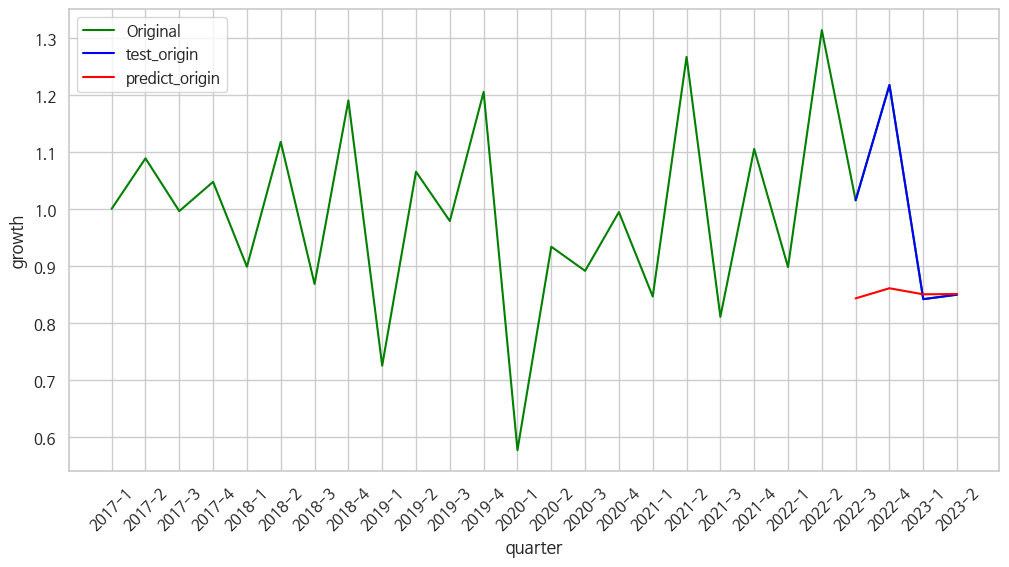

In [145]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [146]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.129695
std      0.172619
min     -0.008481
25%     -0.002968
50%      0.085430
75%      0.218093
max      0.356400
dtype: float64

In [147]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 20ms/step
[[0.33832887]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8261308073997498 


### 시장성

In [148]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_bunsik.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   7.465647e+09  1.000000 -1.250000
1   8.126485e+09  1.088517 -2.564103
2   8.094245e+09  0.996033 -1.739130
3   8.477241e+09  1.047317 -0.877193
4   7.617068e+09  0.898532  1.298701
5   8.511710e+09  1.117452  2.531646
6   7.390622e+09  0.868289  1.659751
7   8.794912e+09  1.190010  0.823045
8   6.377171e+09  0.725098 -0.829876
9   6.792124e+09  1.065068  4.365079
10  6.647088e+09  0.978646  2.962963
11  8.009840e+09  1.205015  0.000000
12  4.621562e+09  0.576986 -0.843882
13  4.315000e+09  0.933667  0.836820
14  3.845813e+09  0.891266  1.646091
15  3.824368e+09  0.994424  0.000000
16  3.236736e+09  0.846345 -0.813008
17  4.099219e+09  1.266467  4.651163
18  3.323262e+09  0.810706  0.766284
19  3.672348e+09  1.105043  2.247191
20  3.297507e+09  0.897929  0.743494
21  4.330897e+09  1.313385  1.831502
22  4.395946e+09  1.015020  0.000000
23  5.350558e+09  1.217157  0.000000
24  3.878552e+09  0.841649 -0.020372
25  3.700956e+09  0.849513 -0.219474
-

In [149]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [150]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.11547252 0.35940151 0.35254842]
 [0.08352019 0.37008033 0.32495386]]


In [151]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [152]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [153]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5840
Epoch 1: val_loss improved from inf to 0.02495, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.5840 - val_loss: 0.0250
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5643
Epoch 2: val_loss improved from 0.02495 to 0.02239, saving model to stock_model.h5
1/1 [==============================] - 0s 80ms/step - loss: 0.5643 - val_loss: 0.0224
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5453
Epoch 3: val_loss improved from 0.02239 to 0.02006, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.5453 - val_loss: 0.0201
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5270
Epoch 4: val_loss improved from 0.02006 to 0.01792, saving model to stock_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.5270 - val_loss: 0.0179
Epoch 5/100
1/1 [=================

In [154]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.11895743]
 [0.13245066]
 [0.12707525]
 [0.12892461]]


In [155]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.165463,0.118957
2022-4,0.078769,0.132451
2023-1,0.169523,0.127075
2023-2,0.155238,0.128925


In [156]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 5].values       # 시장성이 sin_bunsik의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.165463,0.118957,-4.968662e+06,-5415071.0,446408.545713
2022-4,0.078769,0.132451,-5.800844e+06,-5285549.0,-515295.394037
2023-1,0.169523,0.127075,-4.929688e+06,-5337147.5,407459.500000
2023-2,0.155238,0.128925,-5.066816e+06,-5319395.5,252580.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


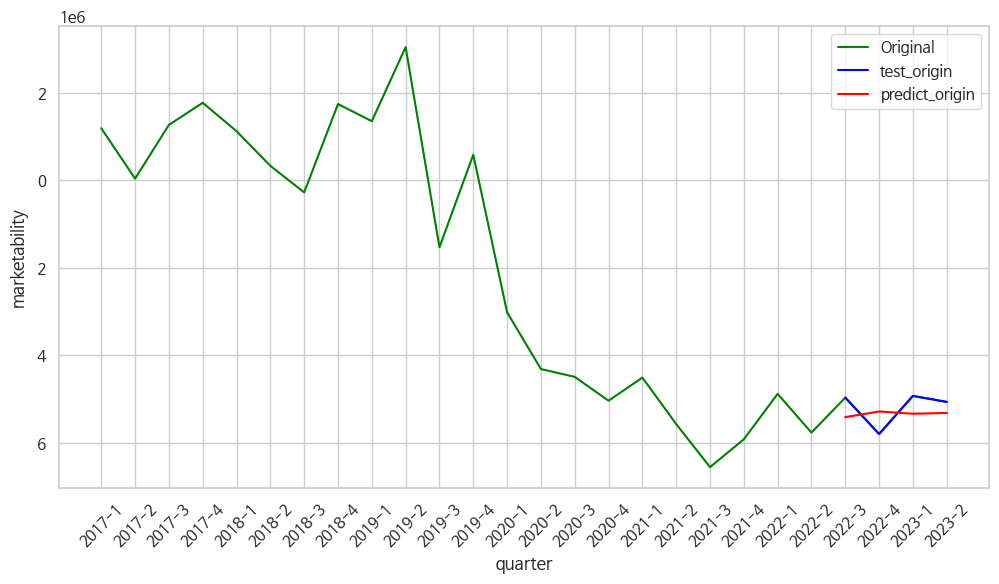

In [157]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [158]:
### error의 요약 통계량
error.describe()

count         4.000000
mean     147788.162919
std      449912.757819
min     -515295.394037
25%       60611.151491
50%      330019.750000
75%      417196.761428
max      446408.545713
dtype: float64

In [159]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 30ms/step
[[0.10900842]]
--------------------------------------------------------------------------------
예측된 시장성  : -5510571.5 


### 순점포증감률

In [160]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '시장성']]
y = sin_bunsik.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   7.465647e+09  1.000000  1.187856e+06
1   8.126485e+09  1.088517  3.564498e+04
2   8.094245e+09  0.996033  1.265094e+06
3   8.477241e+09  1.047317  1.769265e+06
4   7.617068e+09  0.898532  1.120189e+06
5   8.511710e+09  1.117452  3.280421e+05
6   7.390622e+09  0.868289 -2.786735e+05
7   8.794912e+09  1.190010  1.741043e+06
8   6.377171e+09  0.725098  1.348501e+06
9   6.792124e+09  1.065068  3.042091e+06
10  6.647088e+09  0.978646 -1.532132e+06
11  8.009840e+09  1.205015  5.831175e+05
12  4.621562e+09  0.576986 -3.018970e+06
13  4.315000e+09  0.933667 -4.315876e+06
14  3.845813e+09  0.891266 -4.494597e+06
15  3.824368e+09  0.994424 -5.039517e+06
16  3.236736e+09  0.846345 -4.511026e+06
17  4.099219e+09  1.266467 -5.572466e+06
18  3.323262e+09  0.810706 -6.556948e+06
19  3.672348e+09  1.105043 -5.922049e+06
20  3.297507e+09  0.897929 -4.883146e+06
21  4.330897e+09  1.313385 -5.769202e+06
22  4.395946e+09  1.015020 -4.968662e+06
23  5.350558e+09

In [161]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [162]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.11547252 0.35940151 0.16952321]
 [0.08352019 0.37008033 0.15523767]]


In [163]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [164]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [165]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3162
Epoch 1: val_loss improved from inf to 0.36166, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.3162 - val_loss: 0.3617
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3011
Epoch 2: val_loss improved from 0.36166 to 0.35215, saving model to stock_model.h5
1/1 [==============================] - 0s 63ms/step - loss: 0.3011 - val_loss: 0.3522
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2867
Epoch 3: val_loss improved from 0.35215 to 0.34290, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.2867 - val_loss: 0.3429
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2729
Epoch 4: val_loss improved from 0.34290 to 0.33389, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.2729 - val_loss: 0.3339
Epoch 5/100
1/1 [=================

In [166]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 648ms/step
[[0.28920043]
 [0.32819206]
 [0.32901162]
 [0.32928962]]


In [167]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.355372,0.289200
2022-4,0.355372,0.328192
2023-1,0.352548,0.329012
2023-2,0.324954,0.329290


In [168]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_bunsik의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.355372,0.289200,0.000000,-0.477445,0.477445
2022-4,0.355372,0.328192,0.000000,-0.196110,0.196110
2023-1,0.352548,0.329012,-0.020372,-0.190196,0.169824
2023-2,0.324954,0.329290,-0.219474,-0.188191,-0.031284


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


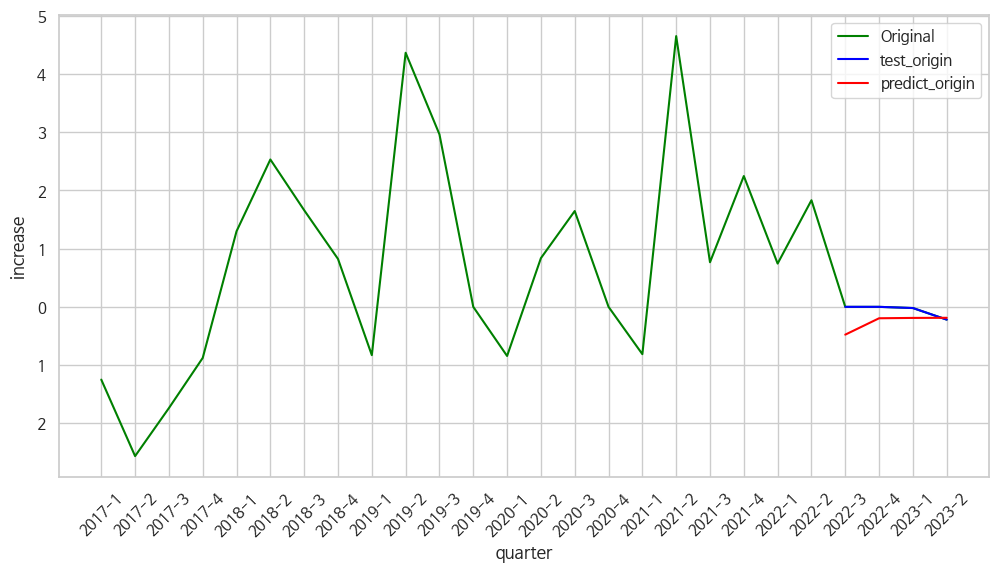

In [169]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [170]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.203024
std      0.209250
min     -0.031284
25%      0.119547
50%      0.182967
75%      0.266444
max      0.477445
dtype: float64

In [171]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 30ms/step
[[0.2762366]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.5709822177886963 


### 추가

In [172]:
sin_bunsik.loc[26] = ['2023-3', '분식전문점', sales, growth, increase, marketability]

<ipython-input-172-5ed3fb4f4302>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bunsik.loc[26] = ['2023-3', '분식전문점', sales, growth, increase, marketability]


In [173]:
sin_bunsik

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,분식전문점,7.465647e+09,1.000000,-1.250000,1.187856e+06
1,2017-2,분식전문점,8.126485e+09,1.088517,-2.564103,3.564498e+04
2,2017-3,분식전문점,8.094245e+09,0.996033,-1.739130,1.265094e+06
3,2017-4,분식전문점,8.477241e+09,1.047317,-0.877193,1.769265e+06
4,2018-1,분식전문점,7.617068e+09,0.898532,1.298701,1.120189e+06
5,2018-2,분식전문점,8.511710e+09,1.117452,2.531646,3.280421e+05
6,2018-3,분식전문점,7.390622e+09,0.868289,1.659751,-2.786735e+05
7,2018-4,분식전문점,8.794912e+09,1.190010,0.823045,1.741043e+06
8,2019-1,분식전문점,6.377171e+09,0.725098,-0.829876,1.348501e+06
9,2019-2,분식전문점,6.792124e+09,1.065068,4.365079,3.042091e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [174]:
### X / y 데이터 생성
X = sin_bunsik[['성장성', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.187856e+06 -1.250000
1   1.088517  3.564498e+04 -2.564103
2   0.996033  1.265094e+06 -1.739130
3   1.047317  1.769265e+06 -0.877193
4   0.898532  1.120189e+06  1.298701
5   1.117452  3.280421e+05  2.531646
6   0.868289 -2.786735e+05  1.659751
7   1.190010  1.741043e+06  0.823045
8   0.725098  1.348501e+06 -0.829876
9   1.065068  3.042091e+06  4.365079
10  0.978646 -1.532132e+06  2.962963
11  1.205015  5.831175e+05  0.000000
12  0.576986 -3.018970e+06 -0.843882
13  0.933667 -4.315876e+06  0.836820
14  0.891266 -4.494597e+06  1.646091
15  0.994424 -5.039517e+06  0.000000
16  0.846345 -4.511026e+06 -0.813008
17  1.266467 -5.572466e+06  4.651163
18  0.810706 -6.556948e+06  0.766284
19  1.105043 -5.922049e+06  2.247191
20  0.897929 -4.883146e+06  0.743494
21  1.313385 -5.769202e+06  1.831502
22  1.015020 -4.968662e+06  0.000000
23  1.217157 -5.800844e+06  0.000000
24  0.841649 -4.929688e+06 -0.020372
25  0.849513 -5.066816e+06 -0.219474
2

In [175]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [176]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.37008033 0.15523767 0.32495386]
 [0.33832887 0.10900846 0.2762366 ]]


In [177]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [178]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [179]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6126
Epoch 1: val_loss improved from inf to 0.01619, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6126 - val_loss: 0.0162
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5928
Epoch 2: val_loss improved from 0.01619 to 0.01419, saving model to stock_model.h5
1/1 [==============================] - 0s 74ms/step - loss: 0.5928 - val_loss: 0.0142
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5736
Epoch 3: val_loss improved from 0.01419 to 0.01242, saving model to stock_model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.5736 - val_loss: 0.0124
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5551
Epoch 4: val_loss improved from 0.01242 to 0.01087, saving model to stock_model.h5
1/1 [==============================] - 0s 68ms/step - loss: 0.5551 - val_loss: 0.0109
Epoch 5/100
1/1 [=================

In [180]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 663ms/step
[[0.10510649]
 [0.09453364]
 [0.09376788]
 [0.08362114]]


In [181]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.380309,0.105106
2023-1,0.115473,0.094534
2023-2,0.083520,0.093768
2023-3,0.074491,0.083621


In [182]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_bunsik의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.380309,0.105106,5.350558e+09,3.820936e+09,1.529622e+09
2023-1,0.115473,0.094534,3.878552e+09,3.762170e+09,1.163820e+08
2023-2,0.083520,0.093768,3.700956e+09,3.757914e+09,-5.695872e+07
2023-3,0.074491,0.083621,3.650770e+09,3.701517e+09,-5.074714e+07


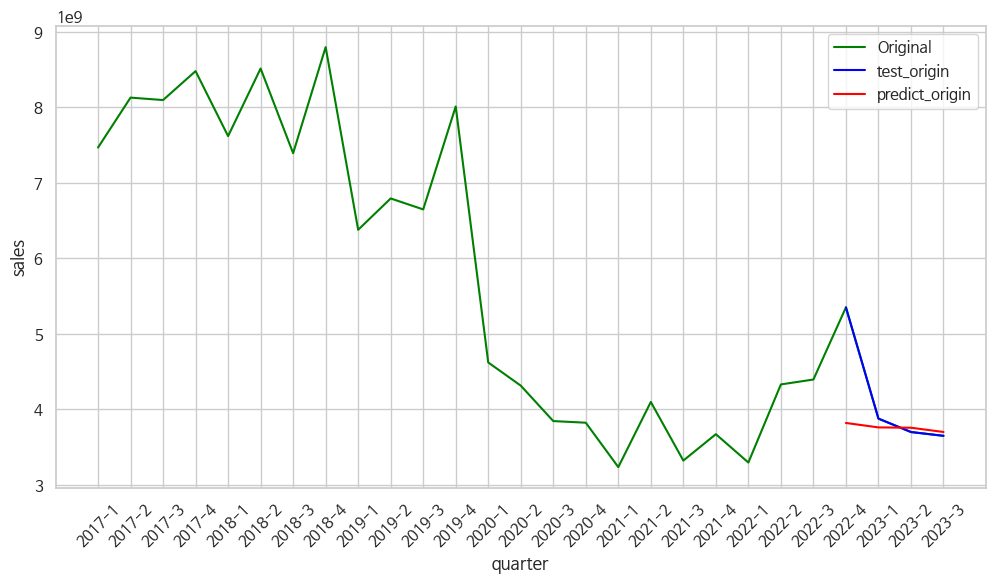

In [183]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [184]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     3.845745e+08
std      7.675756e+08
min     -5.695872e+07
25%     -5.230003e+07
50%      3.281741e+07
75%      4.696919e+08
max      1.529622e+09
dtype: float64

In [185]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 26ms/step
[[0.08173969]]
--------------------------------------------------------------------------------
예측된 매출  : 3691059200.0 


### 성장성

In [186]:
X = sin_bunsik[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   7.465647e+09  1.187856e+06 -1.250000
1   8.126485e+09  3.564498e+04 -2.564103
2   8.094245e+09  1.265094e+06 -1.739130
3   8.477241e+09  1.769265e+06 -0.877193
4   7.617068e+09  1.120189e+06  1.298701
5   8.511710e+09  3.280421e+05  2.531646
6   7.390622e+09 -2.786735e+05  1.659751
7   8.794912e+09  1.741043e+06  0.823045
8   6.377171e+09  1.348501e+06 -0.829876
9   6.792124e+09  3.042091e+06  4.365079
10  6.647088e+09 -1.532132e+06  2.962963
11  8.009840e+09  5.831175e+05  0.000000
12  4.621562e+09 -3.018970e+06 -0.843882
13  4.315000e+09 -4.315876e+06  0.836820
14  3.845813e+09 -4.494597e+06  1.646091
15  3.824368e+09 -5.039517e+06  0.000000
16  3.236736e+09 -4.511026e+06 -0.813008
17  4.099219e+09 -5.572466e+06  4.651163
18  3.323262e+09 -6.556948e+06  0.766284
19  3.672348e+09 -5.922049e+06  2.247191
20  3.297507e+09 -4.883146e+06  0.743494
21  4.330897e+09 -5.769202e+06  1.831502
22  4.395946e+09 -4.968662e+06  0.000000
23  5.350558e+09

In [187]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [188]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.08352019 0.15523767 0.32495386]
 [0.07449098 0.10900846 0.2762366 ]]


In [189]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [190]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [191]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3816
Epoch 1: val_loss improved from inf to 0.41191, saving model to stock_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.3816 - val_loss: 0.4119
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3654
Epoch 2: val_loss improved from 0.41191 to 0.40170, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.3654 - val_loss: 0.4017
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3498
Epoch 3: val_loss improved from 0.40170 to 0.39177, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.3498 - val_loss: 0.3918
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3349
Epoch 4: val_loss improved from 0.39177 to 0.38211, saving model to stock_model.h5
1/1 [==============================] - 0s 115ms/step - loss: 0.3349 - val_loss: 0.3821
Epoch 5/100
1/1 [===============

In [192]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 662ms/step
[[0.3853511 ]
 [0.37091866]
 [0.37161535]
 [0.3383289 ]]


In [193]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.869327,0.385351
2023-1,0.359402,0.370919
2023-2,0.370080,0.371615
2023-3,0.338329,0.338329


In [194]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 3].values       # 성장성이 sin_bunsik의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.869327,0.385351,1.217157,0.860758,0.356400
2023-1,0.359402,0.370919,0.841649,0.850130,-0.008481
2023-2,0.370080,0.371615,0.849513,0.850643,-0.001130
2023-3,0.338329,0.338329,0.826131,0.826131,0.000000


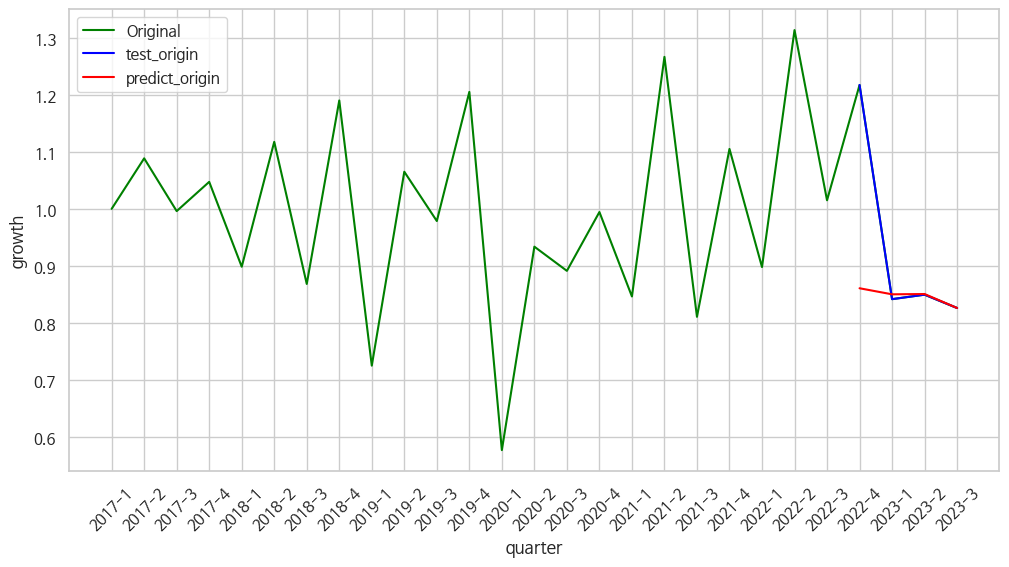

In [195]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [196]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.086697
std      0.179841
min     -0.008481
25%     -0.002968
50%     -0.000565
75%      0.089100
max      0.356400
dtype: float64

In [197]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 34ms/step
[[0.3215498]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8137747049331665 


###시장성

In [198]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_bunsik.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   7.465647e+09  1.000000 -1.250000
1   8.126485e+09  1.088517 -2.564103
2   8.094245e+09  0.996033 -1.739130
3   8.477241e+09  1.047317 -0.877193
4   7.617068e+09  0.898532  1.298701
5   8.511710e+09  1.117452  2.531646
6   7.390622e+09  0.868289  1.659751
7   8.794912e+09  1.190010  0.823045
8   6.377171e+09  0.725098 -0.829876
9   6.792124e+09  1.065068  4.365079
10  6.647088e+09  0.978646  2.962963
11  8.009840e+09  1.205015  0.000000
12  4.621562e+09  0.576986 -0.843882
13  4.315000e+09  0.933667  0.836820
14  3.845813e+09  0.891266  1.646091
15  3.824368e+09  0.994424  0.000000
16  3.236736e+09  0.846345 -0.813008
17  4.099219e+09  1.266467  4.651163
18  3.323262e+09  0.810706  0.766284
19  3.672348e+09  1.105043  2.247191
20  3.297507e+09  0.897929  0.743494
21  4.330897e+09  1.313385  1.831502
22  4.395946e+09  1.015020  0.000000
23  5.350558e+09  1.217157  0.000000
24  3.878552e+09  0.841649 -0.020372
25  3.700956e+09  0.849513 -0.219474
2

In [199]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [200]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.08352019 0.37008033 0.32495386]
 [0.07449098 0.33832887 0.2762366 ]]


In [201]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [202]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [203]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5840
Epoch 1: val_loss improved from inf to 0.02610, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5840 - val_loss: 0.0261
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5643
Epoch 2: val_loss improved from 0.02610 to 0.02342, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.5643 - val_loss: 0.0234
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5453
Epoch 3: val_loss improved from 0.02342 to 0.02097, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.5453 - val_loss: 0.0210
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5270
Epoch 4: val_loss improved from 0.02097 to 0.01873, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.5270 - val_loss: 0.0187
Epoch 5/100
1/1 [=================

In [204]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 992ms/step
[[0.14615674]
 [0.13979371]
 [0.14173627]
 [0.11915354]]


In [205]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.078769,0.146157
2023-1,0.169523,0.139794
2023-2,0.155238,0.141736
2023-3,0.109008,0.119154


In [206]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 5].values       # 시장성이 sin_bunsik의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.078769,0.146157,-5.800844e+06,-5153983.5,-646860.894037
2023-1,0.169523,0.139794,-4.929688e+06,-5215062.5,285374.500000
2023-2,0.155238,0.141736,-5.066816e+06,-5196416.0,129600.500000
2023-3,0.109008,0.119154,-5.510572e+06,-5413188.5,-97383.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


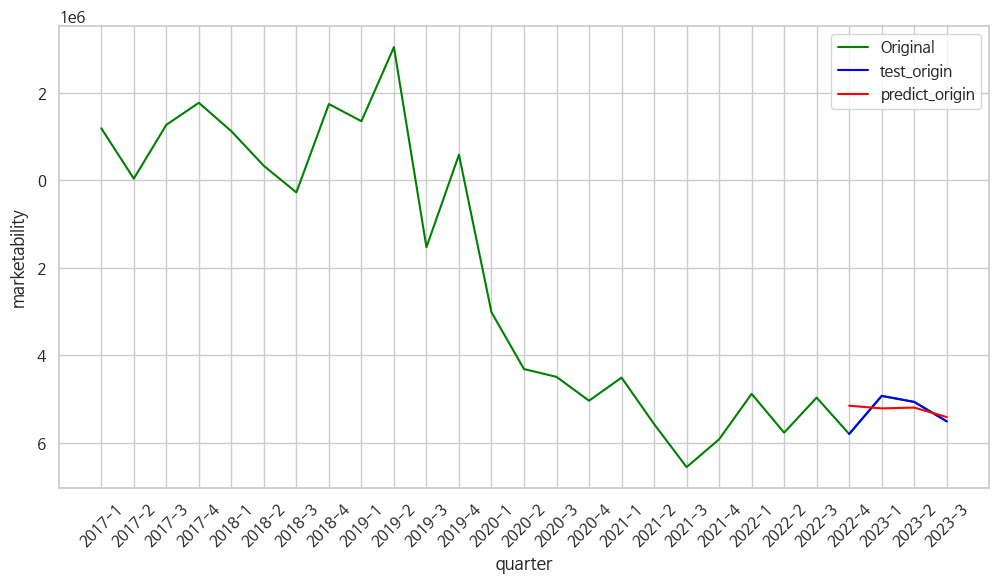

In [207]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [208]:
### error의 요약 통계량
error.describe()

count         4.000000
mean     -82317.223509
std      407857.351954
min     -646860.894037
25%     -234752.473509
50%       16108.750000
75%      168544.000000
max      285374.500000
dtype: float64

In [209]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 41ms/step
[[0.11514623]]
--------------------------------------------------------------------------------
예측된 시장성  : -5451654.5 


### 순점포증감률

In [210]:
### X / y 데이터 생성
X = sin_bunsik[['분기당_매출_금액', '성장성', '시장성']]
y = sin_bunsik.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   7.465647e+09  1.000000  1.187856e+06
1   8.126485e+09  1.088517  3.564498e+04
2   8.094245e+09  0.996033  1.265094e+06
3   8.477241e+09  1.047317  1.769265e+06
4   7.617068e+09  0.898532  1.120189e+06
5   8.511710e+09  1.117452  3.280421e+05
6   7.390622e+09  0.868289 -2.786735e+05
7   8.794912e+09  1.190010  1.741043e+06
8   6.377171e+09  0.725098  1.348501e+06
9   6.792124e+09  1.065068  3.042091e+06
10  6.647088e+09  0.978646 -1.532132e+06
11  8.009840e+09  1.205015  5.831175e+05
12  4.621562e+09  0.576986 -3.018970e+06
13  4.315000e+09  0.933667 -4.315876e+06
14  3.845813e+09  0.891266 -4.494597e+06
15  3.824368e+09  0.994424 -5.039517e+06
16  3.236736e+09  0.846345 -4.511026e+06
17  4.099219e+09  1.266467 -5.572466e+06
18  3.323262e+09  0.810706 -6.556948e+06
19  3.672348e+09  1.105043 -5.922049e+06
20  3.297507e+09  0.897929 -4.883146e+06
21  4.330897e+09  1.313385 -5.769202e+06
22  4.395946e+09  1.015020 -4.968662e+06
23  5.350558e+09

In [211]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [212]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.08352019 0.37008033 0.15523767]
 [0.07449098 0.33832887 0.10900846]]


In [213]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [214]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [215]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3162
Epoch 1: val_loss improved from inf to 0.33718, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3162 - val_loss: 0.3372
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3011
Epoch 2: val_loss improved from 0.33718 to 0.32799, saving model to stock_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 0.3011 - val_loss: 0.3280
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2867
Epoch 3: val_loss improved from 0.32799 to 0.31905, saving model to stock_model.h5
1/1 [==============================] - 0s 106ms/step - loss: 0.2867 - val_loss: 0.3191
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2729
Epoch 4: val_loss improved from 0.31905 to 0.31035, saving model to stock_model.h5
1/1 [==============================] - 0s 209ms/step - loss: 0.2729 - val_loss: 0.3104
Epoch 5/100
1/1 [===============

In [216]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 634ms/step
[[0.32819206]
 [0.32901162]
 [0.32928962]
 [0.2762366 ]]


In [217]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.355372,0.328192
2023-1,0.352548,0.329012
2023-2,0.324954,0.329290
2023-3,0.276237,0.276237


In [218]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_bunsik의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.355372,0.328192,0.000000,-0.196110,0.196110
2023-1,0.352548,0.329012,-0.020372,-0.190196,0.169824
2023-2,0.324954,0.329290,-0.219474,-0.188191,-0.031284
2023-3,0.276237,0.276237,-0.570982,-0.570982,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


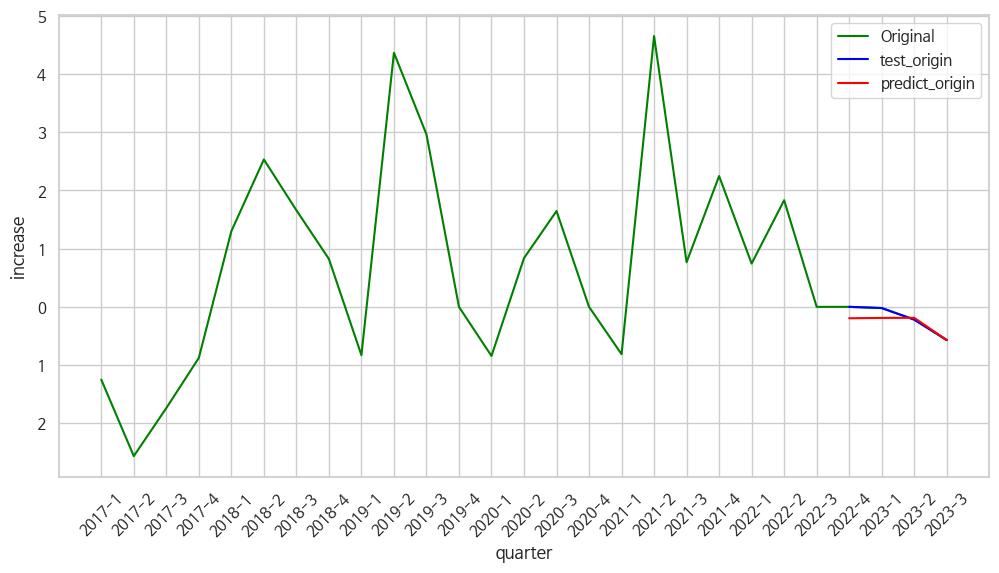

In [219]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [220]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.083663
std      0.115874
min     -0.031284
25%     -0.007821
50%      0.084912
75%      0.176396
max      0.196110
dtype: float64

In [221]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 21ms/step
[[0.2659325]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.6453289985656738 


### 추가

In [222]:
sin_bunsik.loc[27] = ['2023-4', '분식전문점', sales, growth, increase, marketability]

<ipython-input-222-36d9b9377437>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bunsik.loc[27] = ['2023-4', '분식전문점', sales, growth, increase, marketability]


In [223]:
final_sin_bunsik = sin_bunsik
final_sin_bunsik

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,분식전문점,7.465647e+09,1.000000,-1.250000,1.187856e+06
1,2017-2,분식전문점,8.126485e+09,1.088517,-2.564103,3.564498e+04
2,2017-3,분식전문점,8.094245e+09,0.996033,-1.739130,1.265094e+06
3,2017-4,분식전문점,8.477241e+09,1.047317,-0.877193,1.769265e+06
4,2018-1,분식전문점,7.617068e+09,0.898532,1.298701,1.120189e+06
5,2018-2,분식전문점,8.511710e+09,1.117452,2.531646,3.280421e+05
6,2018-3,분식전문점,7.390622e+09,0.868289,1.659751,-2.786735e+05
7,2018-4,분식전문점,8.794912e+09,1.190010,0.823045,1.741043e+06
8,2019-1,분식전문점,6.377171e+09,0.725098,-0.829876,1.348501e+06
9,2019-2,분식전문점,6.792124e+09,1.065068,4.365079,3.042091e+06


## 최종결과

In [224]:
### X / y 데이터 생성
X = sin_bunsik[['성장성', '시장성', '순점포증감률']]
y = sin_bunsik.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  1.187856e+06 -1.250000
1   1.088517  3.564498e+04 -2.564103
2   0.996033  1.265094e+06 -1.739130
3   1.047317  1.769265e+06 -0.877193
4   0.898532  1.120189e+06  1.298701
5   1.117452  3.280421e+05  2.531646
6   0.868289 -2.786735e+05  1.659751
7   1.190010  1.741043e+06  0.823045
8   0.725098  1.348501e+06 -0.829876
9   1.065068  3.042091e+06  4.365079
10  0.978646 -1.532132e+06  2.962963
11  1.205015  5.831175e+05  0.000000
12  0.576986 -3.018970e+06 -0.843882
13  0.933667 -4.315876e+06  0.836820
14  0.891266 -4.494597e+06  1.646091
15  0.994424 -5.039517e+06  0.000000
16  0.846345 -4.511026e+06 -0.813008
17  1.266467 -5.572466e+06  4.651163
18  0.810706 -6.556948e+06  0.766284
19  1.105043 -5.922049e+06  2.247191
20  0.897929 -4.883146e+06  0.743494
21  1.313385 -5.769202e+06  1.831502
22  1.015020 -4.968662e+06  0.000000
23  1.217157 -5.800844e+06  0.000000
24  0.841649 -4.929688e+06 -0.020372
25  0.849513 -5.066816e+06 -0.219474
2

In [225]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [226]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.33832887 0.10900846 0.2762366 ]
 [0.3215498  0.11514626 0.2659325 ]]


In [227]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (22, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (22, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [228]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [229]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5667
Epoch 1: val_loss improved from inf to 0.03113, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5667 - val_loss: 0.0311
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5482
Epoch 2: val_loss improved from 0.03113 to 0.02840, saving model to stock_model.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.5482 - val_loss: 0.0284
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5304
Epoch 3: val_loss improved from 0.02840 to 0.02594, saving model to stock_model.h5
1/1 [==============================] - 0s 74ms/step - loss: 0.5304 - val_loss: 0.0259
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5132
Epoch 4: val_loss improved from 0.02594 to 0.02371, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.5132 - val_loss: 0.0237
Epoch 5/100
1/1 [=================

In [230]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 677ms/step
[[0.12726282]
 [0.12600785]
 [0.11262281]
 [0.10973126]]


In [231]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_bunsik.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2023-1,0.115473,0.127263
2023-2,0.083520,0.126008
2023-3,0.074491,0.112623
2023-4,0.081740,0.109731


In [232]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_bunsik.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_bunsik의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2023-1,0.115473,0.127263,3.878552e+09,3.944085e+09,-65532416.0
2023-2,0.083520,0.126008,3.700956e+09,3.937110e+09,-236154112.0
2023-3,0.074491,0.112623,3.650770e+09,3.862713e+09,-211943424.0
2023-4,0.081740,0.109731,3.691059e+09,3.846641e+09,-155582208.0


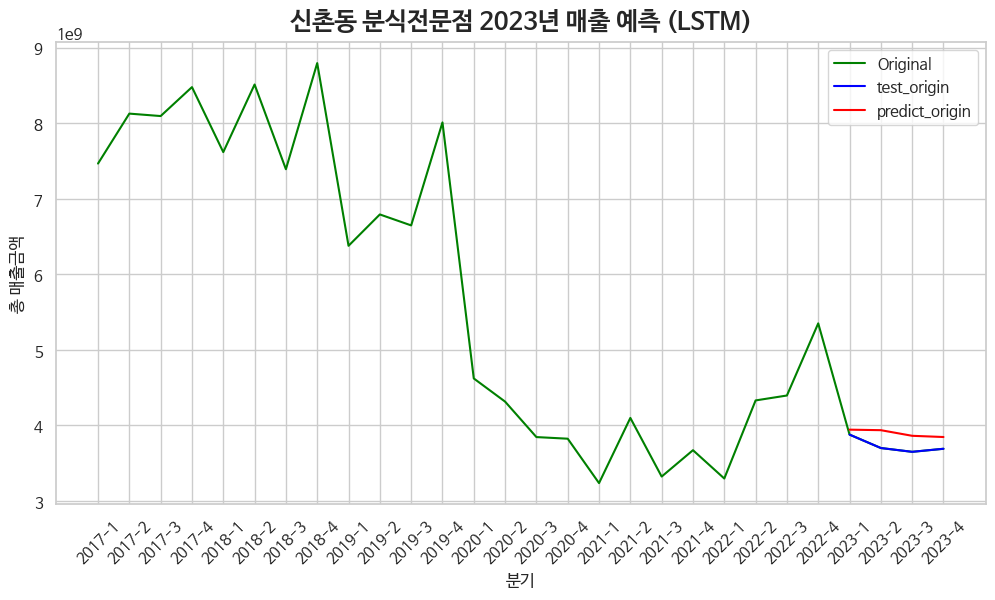

In [233]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_bunsik['분기'], sin_bunsik['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 분식전문점 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()